In [1]:
%matplotlib inline


# Path Tutorial


Defining paths in your Matplotlib visualization.

The object underlying all of the :mod:`matplotlib.patch` objects is
the :class:`~matplotlib.path.Path`, which supports the standard set of
moveto, lineto, curveto commands to draw simple and compound outlines
consisting of line segments and splines.  The ``Path`` is instantiated
with a (N,2) array of (x,y) vertices, and a N-length array of path
codes.  For example to draw the unit rectangle from (0,0) to (1,1), we
could use this code



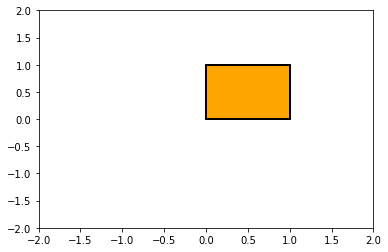

In [2]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

verts = [
   (0., 0.),  # left, bottom
   (0., 1.),  # left, top
   (1., 1.),  # right, top
   (1., 0.),  # right, bottom
   (0., 0.),  # ignored
]

codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

path = Path(verts, codes)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()

The following path codes are recognized

============== =================================  ====================================================================================================================
Code           Vertices                           Description
============== =================================  ====================================================================================================================
``STOP``       1 (ignored)                        A marker for the end of the entire path (currently not required and ignored)
``MOVETO``     1                                  Pick up the pen and move to the given vertex.
``LINETO``     1                                  Draw a line from the current position to the given vertex.
``CURVE3``     2 (1 control point, 1 endpoint)    Draw a quadratic Bézier curve from the current position, with the given control point, to the given end point.
``CURVE4``     3 (2 control points, 1 endpoint)   Draw a cubic Bézier curve from the current position, with the given control points, to the given end point.
``CLOSEPOLY``  1 (point itself is ignored)        Draw a line segment to the start point of the current polyline.
============== =================================  ====================================================================================================================


.. path-curves:


Bézier example
==============

Some of the path components require multiple vertices to specify them:
for example CURVE 3 is a `bézier
<https://en.wikipedia.org/wiki/B%C3%A9zier_curve>`_ curve with one
control point and one end point, and CURVE4 has three vertices for the
two control points and the end point.  The example below shows a
CURVE4 Bézier spline -- the bézier curve will be contained in the
convex hull of the start point, the two control points, and the end
point



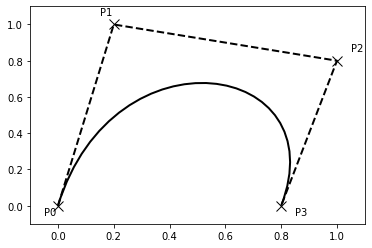

In [3]:
verts = [
   (0., 0.),   # P0
   (0.2, 1.),  # P1
   (1., 0.8),  # P2
   (0.8, 0.),  # P3
]

codes = [
    Path.MOVETO,
    Path.CURVE4,
    Path.CURVE4,
    Path.CURVE4,
]

path = Path(verts, codes)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='none', lw=2)
ax.add_patch(patch)

xs, ys = zip(*verts)
ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

ax.text(-0.05, -0.05, 'P0')
ax.text(0.15, 1.05, 'P1')
ax.text(1.05, 0.85, 'P2')
ax.text(0.85, -0.05, 'P3')

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
plt.show()

.. compound_paths:

Compound paths
==============

All of the simple patch primitives in matplotlib, Rectangle, Circle,
Polygon, etc, are implemented with simple path.  Plotting functions
like :meth:`~matplotlib.axes.Axes.hist` and
:meth:`~matplotlib.axes.Axes.bar`, which create a number of
primitives, e.g., a bunch of Rectangles, can usually be implemented more
efficiently using a compound path.  The reason ``bar`` creates a list
of rectangles and not a compound path is largely historical: the
:class:`~matplotlib.path.Path` code is comparatively new and ``bar``
predates it.  While we could change it now, it would break old code,
so here we will cover how to create compound paths, replacing the
functionality in bar, in case you need to do so in your own code for
efficiency reasons, e.g., you are creating an animated bar plot.

We will make the histogram chart by creating a series of rectangles
for each histogram bar: the rectangle width is the bin width and the
rectangle height is the number of datapoints in that bin.  First we'll
create some random normally distributed data and compute the
histogram.  Because numpy returns the bin edges and not centers, the
length of ``bins`` is 1 greater than the length of ``n`` in the
example below::

    # histogram our data with numpy
    data = np.random.randn(1000)
    n, bins = np.histogram(data, 100)

We'll now extract the corners of the rectangles.  Each of the
``left``, ``bottom``, etc, arrays below is ``len(n)``, where ``n`` is
the array of counts for each histogram bar::

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n

Now we have to construct our compound path, which will consist of a
series of ``MOVETO``, ``LINETO`` and ``CLOSEPOLY`` for each rectangle.
For each rectangle, we need 5 vertices: 1 for the ``MOVETO``, 3 for
the ``LINETO``, and 1 for the ``CLOSEPOLY``.  As indicated in the
table above, the vertex for the closepoly is ignored but we still need
it to keep the codes aligned with the vertices::

    nverts = nrects*(1+3+1)
    verts = np.zeros((nverts, 2))
    codes = np.ones(nverts, int) * path.Path.LINETO
    codes[0::5] = path.Path.MOVETO
    codes[4::5] = path.Path.CLOSEPOLY
    verts[0::5,0] = left
    verts[0::5,1] = bottom
    verts[1::5,0] = left
    verts[1::5,1] = top
    verts[2::5,0] = right
    verts[2::5,1] = top
    verts[3::5,0] = right
    verts[3::5,1] = bottom

All that remains is to create the path, attach it to a
:class:`~matplotlib.patch.PathPatch`, and add it to our axes::

    barpath = path.Path(verts, codes)
    patch = patches.PathPatch(barpath, facecolor='green',
      edgecolor='yellow', alpha=0.5)
    ax.add_patch(patch)



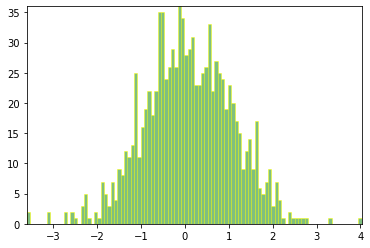

In [4]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.path as path

fig, ax = plt.subplots()
# Fixing random state for reproducibility
np.random.seed(19680801)

# histogram our data with numpy
data = np.random.randn(1000)
n, bins = np.histogram(data, 100)

# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n
nrects = len(left)

nverts = nrects*(1+3+1)
verts = np.zeros((nverts, 2))
codes = np.ones(nverts, int) * path.Path.LINETO
codes[0::5] = path.Path.MOVETO
codes[4::5] = path.Path.CLOSEPOLY
verts[0::5, 0] = left
verts[0::5, 1] = bottom
verts[1::5, 0] = left
verts[1::5, 1] = top
verts[2::5, 0] = right
verts[2::5, 1] = top
verts[3::5, 0] = right
verts[3::5, 1] = bottom

barpath = path.Path(verts, codes)
patch = patches.PathPatch(barpath, facecolor='green',
                          edgecolor='yellow', alpha=0.5)
ax.add_patch(patch)

ax.set_xlim(left[0], right[-1])
ax.set_ylim(bottom.min(), top.max())

plt.show()